In [1]:
import pandas as pd
import numpy as np
import random
import lightgbm as lgb
from copy import deepcopy
import UnbiasedGain

In [2]:
def gen_data(N, rho, task):
    X1 = np.random.randn(N)
    X2 = [random.randint(0,1) for i in range(N)]
    X3 = [random.randint(0,3) for i in range(N)]
    X4 = [random.randint(0,9) for i in range(N)]
    X5 = [random.randint(0,19) for i in range(N)]
    y = rho*(np.array(X2)-0.5) + np.random.randn(N) if task=='regression' else [(i + (1 if random.random()>(1+rho)/2 else 0) )%2 for i in X2]

    X_train = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3, 'X4':X4, 'X5':X5})
    y_train = pd.Series(y)

    return X_train, y_train

In [5]:
import tqdm
import  matplotlib.pyplot as plt

In [6]:
random.seed(2333)
np.random.seed(666)

map_results = {}

rho = 0.
for task in ['regression', 'binclass']:
    one_results = []
    for cases in tqdm.tqdm(range(100)):
        X_train, y_train = gen_data(1000, rho, task)
        X_test, y_test = gen_data(1000, rho, task)
        for c in X_train.columns:
            if 'int' in str(X_train[c].dtype):
                X_train[c] = X_train[c].astype('category')
                X_test[c] = X_test[c].astype('category')
        model = (lgb.LGBMRegressor if task=='regression' else lgb.LGBMClassifier)(n_estimators=1, learning_rate=1)
        model.fit(X_train, y_train.values)
        pred = model.predict(X_test) if task=='regression' else model.predict_proba(X_test)[:,1]
#         print(model.feature_importances_)
        losstool = UnbiasedGain.MSE_tool() if task=='regression' else UnbiasedGain.logloss_tool()
#         print(UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool, biased=True))
#         print(UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool))
        one_results.append( (UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool, biased=True),
                            UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool, biased=False)) )
    map_results[task] = one_results

100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


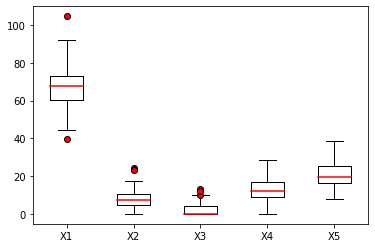

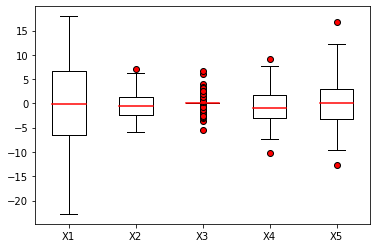

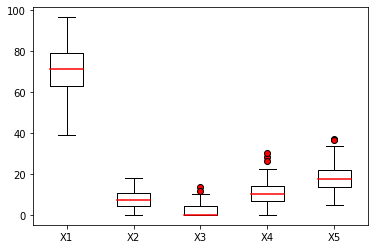

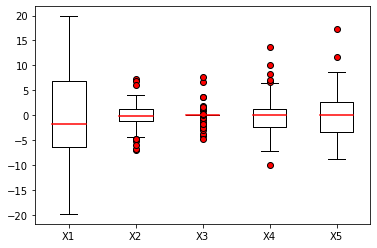

In [14]:
for task in ['regression', 'binclass']:
    one_results = map_results[task]
    for pic in ['biased', 'ours']:
        values = [[] for i in range(5)]
        for biased, ours in one_results:
            for i in range(5):
                values[i].append(biased[i] if pic=='biased' else ours[i])
        plt.boxplot(values,
                    medianprops={'color': 'red', 'linewidth': '1.5'},
                    meanline=True,
                    showmeans=False,
                    meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
                    flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 6},
                    labels=[f'X{i}' for i in range(1,6)])
        plt.show()

In [16]:
random.seed(2333)
np.random.seed(666)


rho_results = []

for i_rho in range(11):
    rho = i_rho/10
    print(rho)
    map_results = {}
    for task in ['regression', 'binclass']:
        one_results = []
        for cases in tqdm.tqdm(range(100)):
            X_train, y_train = gen_data(1000, rho, task)
            X_test, y_test = gen_data(1000, rho, task)
            for c in X_train.columns:
                if 'int' in str(X_train[c].dtype):
                    X_train[c] = X_train[c].astype('category')
                    X_test[c] = X_test[c].astype('category')
            model = (lgb.LGBMRegressor if task=='regression' else lgb.LGBMClassifier)(n_estimators=1, learning_rate=1)
            model.fit(X_train, y_train.values)
            pred = model.predict(X_test) if task=='regression' else model.predict_proba(X_test)[:,1]
    #         print(model.feature_importances_)
            losstool = UnbiasedGain.MSE_tool() if task=='regression' else UnbiasedGain.logloss_tool()
    #         print(UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool, biased=True))
    #         print(UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool))
            one_results.append( (UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool, biased=True),
                                UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool, biased=False)) )
        map_results[task] = one_results
    rho_results.append(map_results)

0.0


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


0.1


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


0.2


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


0.3


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


0.4


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


0.5


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


0.6


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


0.7


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


0.8


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


0.9


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


1.0


100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


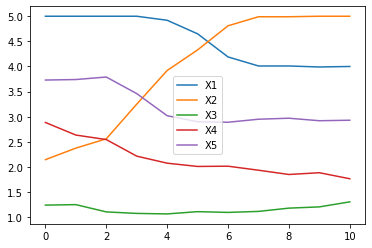

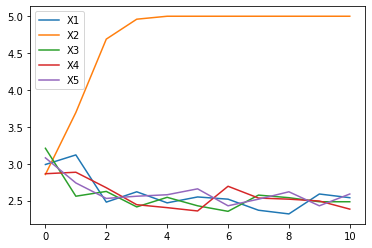

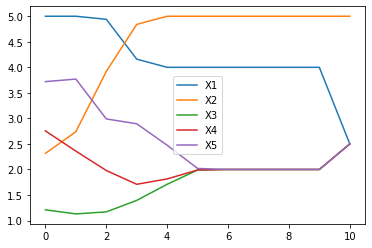

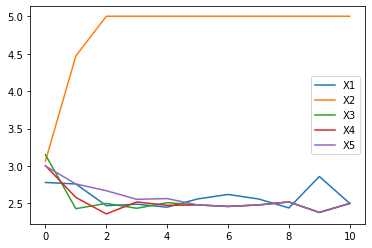

In [23]:
for task in ['regression', 'binclass']:
    for pic in ['biased', 'ours']:
        for feat in range(1,6):
            values = []
            for i in range(11):
                tong = []
                for biased, ours in rho_results[i][task]:
#                     values.append(biased[feat-1] if pic=='biased' else ours[feat-1])
                    lst = biased if pic=='biased' else ours
                    rk, cne = 1., 0.
                    for j in range(5):
                        rk += lst[feat-1] > lst[j]
                        cne += lst[feat-1] == lst[j]
                    tong.append(rk+(cne-1)/2)
                values.append(np.array(tong).mean())
            plt.plot(values)
        plt.legend([f'X{i}' for i in range(1,6)])
        plt.show()

In [1]:
import pandas as pd
import numpy as np
import random
import lightgbm as lgb
import xgboost as xgb
from copy import deepcopy
import UnbiasedGain

In [2]:
def gen_data(N, rho, task):
    X1 = np.random.randn(N)
    X2 = [random.randint(0,1) for i in range(N)]
    X3 = [random.randint(0,3) for i in range(N)]
    X4 = [random.randint(0,9) for i in range(N)]
    X5 = [random.randint(0,19) for i in range(N)]
    y = rho*(np.array(X2)-0.5) + np.random.randn(N) if task=='regression' else [(i + (1 if random.random()>(1+rho)/2 else 0) )%2 for i in X2]
    
    X_train = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3, 'X4':X4, 'X5':X5})
    y_train = pd.Series(y)

    return X_train, y_train

In [5]:
random.seed(2333)
np.random.seed(666)

task = 'regression'
X_train, y_train = gen_data(8, 10, task)
X_test, y_test = gen_data(8, 10, task)
model = (xgb.XGBRegressor if task=='regression' else xgb.XGBClassifier)(n_estimators=3, learning_rate=0.1)
model.fit(X_train, y_train)
pred = model.predict(X_test) if task=='regression' else model.predict_proba(X_test)[:,1]

losstool = UnbiasedGain.MSE_tool() if task=='regression' else UnbiasedGain.logloss_tool()
# print(UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool, biased=True))
print(UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool, biased=False))



0    -0.580919
1     1.444863
2    -0.580919
3     1.444863
4     1.444863
5     1.444863
6    -0.580919
7     1.444863
8    -0.580919
9     1.444863
10    1.444863
11   -0.580919
12   -0.580919
13   -0.580919
14    1.444863
15   -0.580919
Name: _pred, dtype: float64
[0.0, 0.0, 0.0, 0.0, 0.0]


In [6]:
model.predict(X_test)
# X_train

array([-0.5809186,  1.444863 ,  1.444863 , -0.5809186, -0.5809186,
       -0.5809186,  1.444863 , -0.5809186], dtype=float32)

In [7]:
dmp = model.get_booster().get_dump()
print(dmp[0])

0:[X2<1] yes=1,no=2,missing=1
	1:leaf=-0.388732255
	2:leaf=0.342721045



In [40]:
X_train, y_train, y_train.mean()

(         X1  X2  X3  X4  X5
 0  0.824188   0   0   1  14
 1  0.479966   1   3   3  14
 2  1.173468   0   2   2   3
 3  0.909048   1   0   3  17
 4 -0.571721   1   3   7  17
 5 -0.109497   1   3   8  12
 6  0.019028   0   1   0  11
 7 -0.943761   1   3   9  14,
 0    0
 1    1
 2    0
 3    1
 4    1
 5    1
 6    0
 7    1
 dtype: int64,
 0.625)

In [3]:
random.seed(2333)
np.random.seed(666)

task = 'binclass'
X_train, y_train = gen_data(8, 1, task)
X_test, y_test = gen_data(8, 1, task)
model = (xgb.XGBRegressor if task=='regression' else xgb.XGBClassifier)(n_estimators=10, learning_rate=0.1)
model.fit(X_train, y_train)
pred = model.predict(X_test) if task=='regression' else model.predict_proba(X_test)[:,1]

losstool = UnbiasedGain.MSE_tool() if task=='regression' else UnbiasedGain.logloss_tool()
# print(UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool, biased=True))
print(UnbiasedGain.calc_gain(model, X_train, y_train, X_test, y_test, losstool, biased=False))



0     0.170752
1     0.320752
2     0.170752
3     0.170752
4     0.320752
5     0.320752
6     0.170752
7     0.320752
8     0.170752
9     0.170752
10    0.320752
11    0.170752
12    0.170752
13    0.170752
14    0.170752
15    0.170752
Name: _pred, dtype: float64
[0.0, 0.0, 4.5, 0.0, 0.0]
0     0.170752
1     0.320752
2     0.170752
3     0.170752
4     0.320752
5     0.320752
6     0.170752
7     0.320752
8     0.170752
9     0.170752
10    0.320752
11    0.170752
12    0.170752
13    0.170752
14    0.170752
15    0.170752
Name: _pred, dtype: float64
[0.0, 0.0, 0.0, 0.0, 0.0]


In [4]:
model.predict_proba(X_test)

array([[0.45741528, 0.5425847 ],
       [0.45741528, 0.5425847 ],
       [0.4204924 , 0.5795076 ],
       [0.45741528, 0.5425847 ],
       [0.45741528, 0.5425847 ],
       [0.45741528, 0.5425847 ],
       [0.45741528, 0.5425847 ],
       [0.45741528, 0.5425847 ]], dtype=float32)

In [66]:
dmp = model.get_booster().get_dump()

In [67]:
print(len(dmp))

10


In [68]:
print(dmp[0])

0:[X1<0.951731563] yes=1,no=2,missing=1
	1:[X1<0.278041452] yes=3,no=4,missing=3
		3:[X1<-2.38552904] yes=7,no=8,missing=7
			7:[X1<-2.99372101] yes=15,no=16,missing=15
				15:[X1<-3.09939337] yes=29,no=30,missing=29
					29:leaf=-0.0497839861
					30:leaf=0.01966816
				16:[X2<1] yes=31,no=32,missing=31
					31:leaf=-0.140184015
					32:[X5<5] yes=53,no=54,missing=53
						53:leaf=-0.116656832
						54:leaf=-0.0427377373
			8:[X4<9] yes=17,no=18,missing=17
				17:[X1<-2.17010808] yes=33,no=34,missing=33
					33:[X5<13] yes=55,no=56,missing=55
						55:leaf=0.0147509528
						56:leaf=-0.064877525
					34:[X1<-1.94027448] yes=57,no=58,missing=57
						57:leaf=-0.0868694112
						58:leaf=-0.0517246425
				18:[X5<16] yes=35,no=36,missing=35
					35:[X3<3] yes=59,no=60,missing=59
						59:leaf=-0.0688411817
						60:leaf=-0.0235054567
					36:[X1<-0.269213647] yes=61,no=62,missing=61
						61:leaf=-0.0625419021
						62:leaf=-0.155203387
		4:[X1<0.294585407] yes=9,no=10,missing=9
			9:[X1<

In [69]:
def convert_str_to_tree(s):
    # a node should be {'split_feature':?, 'decision_type':'<', 'threshold':?, 'default_left':True}
    # if leaf, 'leaf_value':?;  else, 'left_child':?,'right_child':?
    stack = []
    def pop_back(stack):
        if 'left_child' in stack[-2][1]: stack[-2][1]['right_child'] = stack[-1][1]
        else: stack[-2][1]['left_child'] = stack[-1][1]
        return stack[:-1]
    
    for line in s.split('\n'):
        if len(line)<1: continue
        cnt = sum([int(o=='\t') for o in line])
        while len(stack) and cnt<=stack[-1][0]:
            stack = pop_back(stack)
        if '[' in line:
            keys = line.split('[')[-1].split(']')[0]
            node = {'split_feature':keys.split('<')[0], 'decision_type':'<', 'threshold':keys.split('<')[1], 'default_left':True}
        else:
            value = float(line.split('=')[-1])
            node = {'leaf_value':value, 'leaf_weight':None, 'leaf_count':None}
        stack.append((cnt, node))
    
    while len(stack)>=2:
        stack = pop_back(stack)
    
    return stack[0][1]

In [70]:
convert_str_to_tree(dmp[0])

{'split_feature': 'X1',
 'decision_type': '<',
 'threshold': '0.951731563',
 'default_left': True,
 'left_child': {'split_feature': 'X1',
  'decision_type': '<',
  'threshold': '0.278041452',
  'default_left': True,
  'left_child': {'split_feature': 'X1',
   'decision_type': '<',
   'threshold': '-2.38552904',
   'default_left': True,
   'left_child': {'split_feature': 'X1',
    'decision_type': '<',
    'threshold': '-2.99372101',
    'default_left': True,
    'left_child': {'split_feature': 'X1',
     'decision_type': '<',
     'threshold': '-3.09939337',
     'default_left': True,
     'left_child': {'leaf_value': -0.0497839861,
      'leaf_weight': None,
      'leaf_count': None},
     'right_child': {'leaf_value': 0.01966816,
      'leaf_weight': None,
      'leaf_count': None}},
    'right_child': {'split_feature': 'X2',
     'decision_type': '<',
     'threshold': '1',
     'default_left': True,
     'left_child': {'leaf_value': -0.140184015,
      'leaf_weight': None,
      'le

In [71]:
type(model)

xgboost.sklearn.XGBRegressor

In [72]:
isinstance(model, xgb.sklearn.XGBRegressor)

True